Transaction Table *

* TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
* TransactionAMT: transaction payment amount in USD
* ProductCD: product code, the product for each transaction
* card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
* addr: address
* dist: distance
* P_ and (R__) emaildomain: purchaser and recipient email domain
* C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
* D1-D15: timedelta, such as days between previous transaction, etc.
* M1-M9: match, such as names on card and address, etc.
* Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

Categorical Features:

* ProductCD
* card1 - card6
* addr1, addr2
* P_emaildomain
* R_emaildomain
* M1 - M9

Identity Table *

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

* Categorical Features:
* DeviceType
* DeviceInfo
* id_12 - id_38



In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import pandas as pd
import numpy as np
import gc
import re
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
%matplotlib inline

from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.svm import OneClassSVM
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from mlxtend.feature_selection import SequentialFeatureSelector 
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier 
plt.rcParams['figure.figsize'] = (16,12)
skip_start = True
speed = True
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.24.2.


In [2]:
if not skip_start:
    train_identity = pd.read_csv('data/ieee-fraud-detection/train_identity.csv')
    train_transaction = pd.read_csv('data/ieee-fraud-detection/train_transaction.csv')

In [3]:
if not skip_start:
    train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
    train = train.drop(columns=[x for x in train.columns if x.startswith("V")])
    train.shape

In [4]:
if not skip_start:
    del train_identity, train_transaction
    gc.collect()


In [5]:
if not skip_start:
    # move isFraud to end
    isFraud = train['isFraud']
    train.drop(labels=['isFraud'], axis=1, inplace = True)
    train['isFraud'] = isFraud
    del isFraud

    # print amount of each
    frauds = train.shape[0]
    yes = train['isFraud'].sum()
    no = frauds - yes
    print('{} frauds'.format(frauds))
    print('{} yes \n{} no'.format(yes,no))

In [6]:
if not skip_start:
    print(list(train.columns))


In [7]:
if not skip_start:
    train.to_pickle("train.pkl")

In [8]:
if skip_start:
    train = pd.read_pickle("train.pkl")
if speed:
    train = train.sample(n=100000)

# First thing is first: Hold Out Validation

test part needs to be separate

In [9]:
if speed:
    y = train['isFraud']   #target classes
    X = train.drop('isFraud', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=1/3)
    print("X_train shape: ",X_train.shape)
    print("X_test shape: ",X_test.shape)
    print("y_train.value_counts: ",y_train.value_counts())
    print("y_test.value_counts: ",y_test.value_counts())

X_train shape:  (66666, 94)
X_test shape:  (33334, 94)
y_train.value_counts:  0    64347
1     2319
Name: isFraud, dtype: int64
y_test.value_counts:  0    32209
1     1125
Name: isFraud, dtype: int64


In [10]:
if speed:
    train  = pd.concat([X_train,y_train], axis=1)
    test = pd.concat([X_test,y_test], axis=1)

In [11]:
if speed:
    del X
    del y
    gc.collect()

In [12]:
if speed:
    print(train.columns)
    print(test.columns)

Index(['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD',
       'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2',
       'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3',
       'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14',
       'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11',
       'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7',
       'M8', 'M9', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06',
       'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14',
       'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22',
       'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30',
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo', 'isFraud'],
      dtype='object')
Index(['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD',
       'card

In [13]:
if speed:
    print(train.shape)
    print(test.shape)

(66666, 95)
(33334, 95)


## add new column for same emails

In [14]:
train['is_email_same'] = train.apply(lambda x: x['P_emaildomain']== x['R_emaildomain'] and x['R_emaildomain'] != np.nan, axis=1)

In [15]:
# imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp = SimpleImputer(strategy='constant', fill_value='missing')
imp.fit(train[train.columns[train.dtypes == object]])
train[train.columns[train.dtypes == object]] = imp.transform(train[train.columns[train.dtypes == object]])

# Start to prepare Train for finding best models

## Remove too many NaN on rows

In [16]:
def drop_more_than_N_Nan(N): # of the 68 columns, only 20 allowed to be NaN
    print(train.shape)
    train.dropna(thresh=train.shape[1]-N, axis=0, inplace=True)
    print(train.shape)
    
drop_more_than_N_Nan(20)
print(train.shape, list(train.columns))

(66666, 96)
(5234, 96)
(5234, 96) ['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'isFraud', 'is_email_same']


In [17]:
train.set_index("TransactionID", inplace=True)
train.shape, train.columns

((5234, 95),
 Index(['TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2',
        'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2',
        'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6',
        'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3',
        'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14',
        'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_01',
        'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09',
        'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17',
        'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25',
        'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33',
        'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo',
        'isFraud', 'is_email_same'],
       dtype='object'))

## convert TransactionDT to datetime

In [18]:
import datetime as dt

start = dt.datetime(2021,1,1,0,0) # need a reference point use this for train and test
train["TransactionDAYOFWEEK"] = train["TransactionDT"].apply(lambda x: start + pd.Timedelta(seconds=x)).dt.day_name()
train["TransactionDAYOFWEEK"]

TransactionID
3183192       Sunday
3463016       Sunday
3096339       Monday
3526947       Monday
3121697       Monday
             ...    
3063318    Wednesday
3109641     Thursday
3138573     Saturday
3053466       Monday
3524436       Sunday
Name: TransactionDAYOFWEEK, Length: 5234, dtype: object

## remove columns over ??% missing

In [19]:
columns_dropped = []

def remove_columns(perc_limit):
    missing_perc = (train.isna().sum() / train.isna().count()).sort_values(ascending=False)
    print("remove_columns limit:", perc_limit)
    print("missing perc (first 40):", dict(missing_perc[:40]))
    perc_too_high_cols = missing_perc[missing_perc > perc_limit].index
    print("Columns over the limit (first 40):",perc_too_high_cols[:40])
    print("before drop:", train.shape)
    print("perc_too_high_cols columns:", perc_too_high_cols)
    columns_dropped.extend(perc_too_high_cols)
    train.drop(columns=perc_too_high_cols, inplace=True)
#     object_columns = train.columns[(train.dtypes == object) & (~train.columns.isin(['isFraud','TransactionDAYOFWEEK','is_email_same','DeviceInfo','id_33','id_30','id_31','P_emaildomain', 'R_emaildomain']))]
#     print("object columns:", object_columns)
#     columns_dropped.extend(object_columns)
#     train.drop(columns=object_columns, inplace=True)
    print("after drop:", train.shape)
    
    
remove_columns(0.80)
print("DROP:",columns_dropped)

remove_columns limit: 0.8
missing perc (first 40): {'dist1': 1.0, 'D11': 1.0, 'id_24': 0.9121131066106228, 'id_08': 0.9050439434466947, 'id_07': 0.9050439434466947, 'id_25': 0.9048528849828047, 'id_26': 0.9044707680550248, 'id_21': 0.9044707680550248, 'id_22': 0.9044707680550248, 'id_32': 0.6604891096675582, 'id_18': 0.6452044325563623, 'addr1': 0.6354604508979748, 'addr2': 0.6354604508979748, 'id_14': 0.6247611769201376, 'D2': 0.5248376003056936, 'D3': 0.504012227741689, 'dist2': 0.4931218952999618, 'D5': 0.43064577760794803, 'D7': 0.3704623614826137, 'D12': 0.3454337027130302, 'D13': 0.2896446312571647, 'D14': 0.27493312953763854, 'D4': 0.27435995414596864, 'D6': 0.21742453190676347, 'D10': 0.2164692395873137, 'D15': 0.20252197172334735, 'id_03': 0.15819640810087887, 'id_04': 0.15819640810087887, 'D9': 0.10087886893389378, 'D8': 0.10087886893389378, 'id_09': 0.10087886893389378, 'id_10': 0.10087886893389378, 'id_13': 0.047382499044707684, 'id_06': 0.019870080244554833, 'id_05': 0.019

## check categories

In [20]:
def check_categories():
    for col, values in train.loc[:, train.dtypes == object].iteritems():
        num_uniques = values.nunique()
        if num_uniques > 5:
            print ('{name}: {num_unique}'.format(name=col, num_unique=num_uniques))
            print (values.unique()[:20], "....")
            print ("")
            print (values.value_counts()[:10])
            print ("")
            print (train.loc[train["isFraud"] == 1,["isFraud",col]].groupby(col).agg('count').sort_values('isFraud', ascending=False).head(15))
            print ('\n')
            
check_categories()

P_emaildomain: 47
['gmail.com' 'anonymous.com' 'missing' 'aol.com' 'hotmail.com'
 'outlook.com' 'yahoo.com' 'live.com.mx' 'att.net' 'live.com'
 'yahoo.com.mx' 'cox.net' 'rocketmail.com' 'prodigy.net.mx' 'comcast.net'
 'verizon.net' 'msn.com' 'icloud.com' 'outlook.es' 'yahoo.co.uk'] ....

gmail.com        1964
hotmail.com      1185
missing           673
anonymous.com     588
yahoo.com         218
outlook.com       126
aol.com            73
yahoo.com.mx       69
live.com.mx        32
comcast.net        32
Name: P_emaildomain, dtype: int64

               isFraud
P_emaildomain         
gmail.com          439
hotmail.com        124
missing             36
outlook.com         35
anonymous.com       18
yahoo.com           14
outlook.es           6
icloud.com           4
live.com             3
yahoo.com.mx         2
live.com.mx          2
mail.com             2
hotmail.es           2
me.com               1
aol.com              1


R_emaildomain: 48
['gmail.com' 'anonymous.com' 'yahoo.com' 'mis

In [21]:
def check_num_cols():
    for col, values in train.loc[:, train.dtypes != object].iteritems():
        num_uniques = values.nunique()
        if num_uniques > 2:
            print ('{name}: {num_unique}'.format(name=col, num_unique=num_uniques))
            print (values.value_counts().nlargest(10))
            print ('\n')
            
check_num_cols()

TransactionDT: 5232
4226889     2
5622042     2
15220736    1
941385      1
4247190     1
9486146     1
10110274    1
12957247    1
6835519     1
14583102    1
Name: TransactionDT, dtype: int64


TransactionAmt: 1965
100.0    306
50.0     232
150.0    156
25.0     144
200.0    120
20.0      76
75.0      66
300.0     66
250.0     65
40.0      55
Name: TransactionAmt, dtype: int64


card1: 1200
15885    507
3154     242
9633     169
4461     141
5812     126
15775    121
9026     114
16136    114
13832    109
6019      81
Name: card1, dtype: int64


card2: 211
545.0    820
408.0    407
555.0    390
375.0    286
500.0    236
583.0    233
204.0    166
399.0    164
103.0    154
481.0    138
Name: card2, dtype: int64


card3: 54
185.0    2814
150.0    1917
106.0     104
144.0      45
117.0      44
146.0      41
119.0      31
102.0      26
147.0      21
162.0      19
Name: card3, dtype: int64


card5: 51
226.0    1409
224.0    1067
138.0     939
137.0     485
102.0     424
195.0     225
219.0

In [22]:
def get_perc(x):
    return x.sum()/x.count()

In [23]:
email_repl = ['gmail', 'hotmail', 'yahoo', 'aol', 'anonymous', 'outlook', 'protonmail',"missing"]
DeviceInfo_repl = ['rv', 'windows', 'ios', 'build', 'trident', 'moto', "missing"]
id_31_repl = ['icedragon', 'firefox', 'android', 'chrome', 'safari', 'ie', 'edge', 'samsung', 'opera',"missing"]
id_30_repl = ['Android', 'Mac', 'Windows', 'iOS', "missing"]
id_33_repl = ['1920x1080', '1366x768', "2208x1242","missing"]

In [24]:
train.loc[train['P_emaildomain'].isna(), 'P_emaildomain'] = "missing"
for i in email_repl:
    train.loc[train['P_emaildomain'].str.contains(i), 'P_emaildomain'] = i
train.loc[~train['P_emaildomain'].isin(email_repl), 'P_emaildomain'] = "other"

train.loc[train['R_emaildomain'].isna(), 'R_emaildomain'] = "missing"
for i in email_repl:
    train.loc[train['R_emaildomain'].str.contains(i), 'R_emaildomain'] = i
train.loc[~train['R_emaildomain'].isin(email_repl), 'R_emaildomain'] = "other"

train.loc[train['id_31'].isna(), 'id_31'] = "missing"
for i in id_31_repl:
    train.loc[train['id_31'].str.contains(i), 'id_31'] = i
train.loc[~train['id_31'].isin(id_31_repl), 'id_31'] = "other"

train.loc[train['id_30'].isna(), 'id_30'] = "missing"
for i in id_30_repl:
    train.loc[train['id_30'].str.contains(i), 'id_30'] = i
train.loc[~train['id_30'].isin(id_30_repl), 'id_30'] = "other"

train.loc[train['id_33'].isna(), 'id_33'] = "missing"
for i in id_33_repl:
    train.loc[train['id_33'].str.contains(i), 'id_33'] = i
train.loc[~train['id_33'].isin(id_33_repl), 'id_33'] = "other"

train.loc[train['DeviceInfo'].isna(), 'DeviceInfo'] = "missing"
for i in DeviceInfo_repl:
    train.loc[train['DeviceInfo'].str.contains(i), 'DeviceInfo'] = i
train.loc[~train['DeviceInfo'].isin(DeviceInfo_repl), 'DeviceInfo'] = "other"
train['DeviceInfo'].value_counts().head(15)

other      4107
missing    1011
rv          109
moto          7
Name: DeviceInfo, dtype: int64

In [25]:
def missing_vals(df):
    x = []
    for col in df.columns:
        vals = df[col].value_counts().shape[0]
        missing = round((df[col].isna().sum()/df[col].shape[0])*100,2)
        x.append([col,vals,missing])
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print(pd.DataFrame(x, columns=["col","vals","missing"]).set_index("col"))

missing_vals(train)

                      vals  missing
col                                
TransactionDT         5232     0.00
TransactionAmt        1965     0.00
ProductCD                4     0.00
card1                 1200     0.00
card2                  211     0.29
card3                   54     0.10
card4                    5     0.00
card5                   51     0.38
card6                    3     0.00
addr1                  102    63.55
addr2                   15    63.55
dist2                  513    49.31
P_emaildomain            8     0.00
R_emaildomain            8     0.00
C1                     169     0.00
C2                     213     0.00
C3                       8     0.00
C4                     113     0.00
C5                       1     0.00
C6                     111     0.00
C7                     100     0.00
C8                     131     0.00
C9                       1     0.00
C10                    154     0.00
C11                    129     0.00
C12                    116  

In [26]:
print(train.sample(5).T.to_string())

TransactionID                3285862         3506717     3047749     3544641     3068021
TransactionDT                7396409        13641051     1378428    14756969     1735974
TransactionAmt                 200.0           100.0      44.308       9.099       6.122
ProductCD                          R               S           C           C           C
card1                           9043            6019        3154        8755       16136
card2                          170.0           583.0       408.0       500.0       204.0
card3                          150.0           150.0       185.0       185.0       185.0
card4                           visa            visa  mastercard  mastercard        visa
card5                          195.0           226.0       224.0       224.0       138.0
card6                         credit          credit       debit      credit       debit
addr1                          387.0           264.0         NaN         NaN         NaN
addr2                

In [27]:
# remove columns with only 1 values and not missing
# train = pd.read_pickle("trainbeforeScale.pkl")
cols_remove = train.columns[train.apply(lambda x: x.value_counts().shape[0]) == 1]
columns_dropped.extend(cols_remove)
train.drop(columns=cols_remove, inplace=True)
print("removed:", cols_remove)
print("total dropped:", columns_dropped)

removed: Index(['C5', 'C9', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9'], dtype='object')
total dropped: ['dist1', 'D11', 'id_24', 'id_08', 'id_07', 'id_25', 'id_26', 'id_21', 'id_22', 'C5', 'C9', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9']


In [28]:
# these are T or F 
def convert_binary(x):
    return x.map({"T":1, "F":0})

# train[["id_35","id_36","id_37","id_38"]] = train[["id_35","id_36","id_37","id_38"]].apply(convert_binary)

In [29]:
print(train.sample(5).T.to_string())

TransactionID            3553609   3568494           3076775    3214197     3386337
TransactionDT           15021239  15528774           1882350    5363201    10080731
TransactionAmt            30.864    28.035             500.0     77.338      31.418
ProductCD                      C         C                 R          C           C
card1                      10086     15885             13252      10175        1976
card2                      500.0     545.0             399.0      176.0       545.0
card3                      185.0     185.0             150.0      185.0       185.0
card4                 mastercard      visa  american express       visa        visa
card5                      224.0     138.0             150.0      226.0       102.0
card6                     credit     debit            credit      debit      credit
addr1                        NaN       NaN             204.0        NaN         NaN
addr2                        NaN       NaN              87.0        NaN     

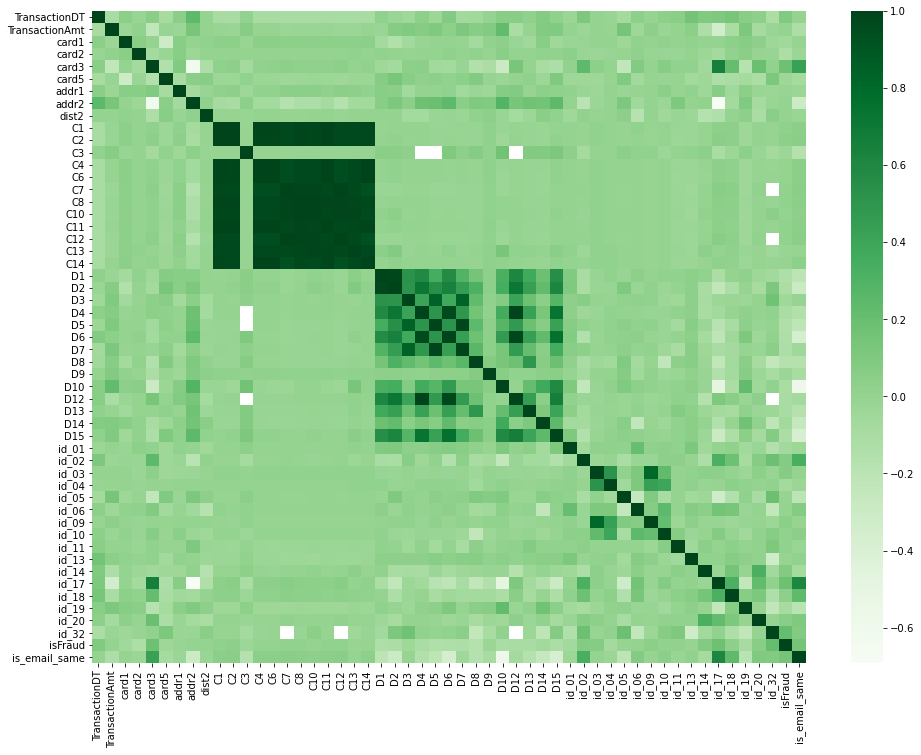

In [30]:
corrMatrix = train.corr()
sns.heatmap(corrMatrix, annot=False, cmap="Greens")
plt.show()

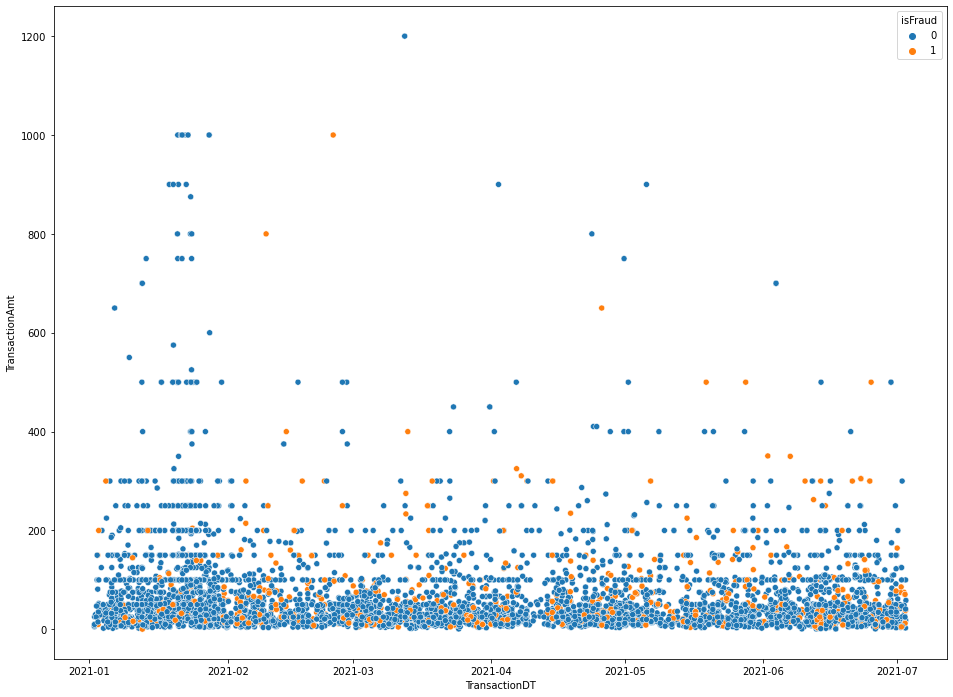

In [31]:
timeseries = train["TransactionDT"].apply(lambda x: start + pd.Timedelta(seconds=x))
timeseries
fig, ax = plt.subplots()

sns.scatterplot(x=timeseries, y="TransactionAmt", hue='isFraud', data=train) 
plt.show()

# ax.scatter(data=gdf, x=train["TransactionAmt"])
# # ax.scatter(timeseries, train["TransactionAmt"], label='TransactionAmt', s=10)
# ax.set_xlabel('Time')
# ax.set_ylabel('TransactionAmt')
# ax.legend()
# plt.show()

# remove outliers and fill missing

In [32]:
print(train.shape)
train = train[train.loc[:,'TransactionAmt'] < 1000]
print(train.shape)

(5234, 77)
(5218, 77)


In [33]:
percent_missing = train.isna().sum() / len(train)
percent_missing.sort_values(ascending=False)[:40]

id_32         0.662323
id_18         0.645650
addr1         0.637409
addr2         0.637409
id_14         0.626485
D2            0.523764
D3            0.503641
dist2         0.491951
D5            0.431200
D7            0.369874
D12           0.343427
D13           0.288041
D4            0.274435
D14           0.273093
D6            0.216366
D10           0.215791
D15           0.202185
id_04         0.158490
id_03         0.158490
id_09         0.101188
D8            0.101188
id_10         0.101188
D9            0.101188
id_13         0.047528
id_06         0.019739
id_05         0.019739
id_20         0.015523
id_19         0.014182
id_17         0.013798
card5         0.003833
card2         0.002875
D1            0.001150
card3         0.000958
id_35         0.000000
DeviceInfo    0.000000
id_15         0.000000
id_34         0.000000
id_33         0.000000
id_37         0.000000
id_31         0.000000
dtype: float64

In [34]:
train_hot_categories = {}
def onehot(df, col, categories=None):
    print("using", col, categories)
    print("unique values:", df[col].unique().tolist())
    if categories:
        enc = OneHotEncoder(sparse=False, categories=(categories,), handle_unknown="ignore")
    else:
        enc = OneHotEncoder(sparse=False, handle_unknown="ignore")
    array_hot_encoded = enc.fit_transform(df[[col]])
    print("get_feature_names:", enc.get_feature_names([col]))
    print("categories_:", enc.categories_)
    train_hot_categories[col] = list(enc.categories_[0])
    hot_array = pd.DataFrame(array_hot_encoded, columns=enc.get_feature_names([col]))
    print("hot_array.columns", hot_array.columns)
    return pd.concat([df.drop(columns=[col]).reset_index(drop=True), hot_array], axis=1)

In [35]:
num_cols_mask = (train.dtypes != object) & (train.columns != 'isFraud') & (train.nunique()>2)
not_num_cols_mask = (train.dtypes == object)
num_cols = train.columns[num_cols_mask]
print("num_cols", num_cols)
not_num_cols = train.columns[not_num_cols_mask]
print("not_num_cols", not_num_cols)

imp = SimpleImputer(strategy='constant', fill_value='missing')
imp.fit(train[not_num_cols])
train[not_num_cols] = imp.transform(train[not_num_cols])

train.reset_index(inplace=True)
for col in not_num_cols:
    train = onehot(df=train, col=str(col), categories=None)

scaler = StandardScaler()
# scaler = RobustScaler(quantile_range=(25, 75))
train[num_cols] = scaler.fit_transform(train[num_cols])


nan_cols = train.columns[(train.isna().any())  & (train.nunique() != 2) & ((train.isna().sum() / len(train)) < 0.40)]
print("missing:", dict(train[nan_cols].isna().mean()))
print("KNNImputer cols:", nan_cols)
# done in chunks cause or else be here all day
# for i in range(0, len(nan_cols), 2):
#     chunk = nan_cols[i:i+2]
#     print(chunk)
#     imp_kNN = KNNImputer(missing_values = np.nan, n_neighbors=5)
#     imp_kNN.fit(train[chunk])
#     train[chunk] = imp_kNN.transform(train[chunk])
#     print(train.shape)

imp_kNN = KNNImputer(missing_values = np.nan, n_neighbors=3)
imp_kNN.fit(train[nan_cols])
train[nan_cols] = imp_kNN.transform(train[nan_cols])
print(train.shape)
        
        
nan_cols = train.columns[(train.isna().any())  & (train.nunique() == 2) | ((train.isna().sum() / len(train)) > 0.40) ]
print("SimpleImputer cols:", nan_cols)
imp = SimpleImputer(missing_values=np.nan, strategy='median')
imp.fit(train[nan_cols])
train[nan_cols] = imp.transform(train[nan_cols])

train.set_index("TransactionID", inplace=True)
# train.drop(columns="index", inplace=True)

num_cols Index(['TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5',
       'addr1', 'addr2', 'dist2', 'C1', 'C2', 'C3', 'C4', 'C6', 'C7', 'C8',
       'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6',
       'D7', 'D8', 'D9', 'D10', 'D12', 'D13', 'D14', 'D15', 'id_01', 'id_02',
       'id_03', 'id_04', 'id_05', 'id_06', 'id_09', 'id_10', 'id_11', 'id_13',
       'id_14', 'id_17', 'id_18', 'id_19', 'id_20', 'id_32'],
      dtype='object')
not_num_cols Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M4',
       'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30',
       'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo', 'TransactionDAYOFWEEK'],
      dtype='object')
using ProductCD None
unique values: ['C', 'R', 'S', 'H']
get_feature_names: ['ProductCD_C' 'ProductCD_H' 'ProductCD_R' 'ProductCD_S']
categories_: [array(['C', 'H', 'R', 'S'], dtype=object)]
hot_a

using TransactionDAYOFWEEK None
unique values: ['Sunday', 'Monday', 'Thursday', 'Saturday', 'Tuesday', 'Friday', 'Wednesday']
get_feature_names: ['TransactionDAYOFWEEK_Friday' 'TransactionDAYOFWEEK_Monday'
 'TransactionDAYOFWEEK_Saturday' 'TransactionDAYOFWEEK_Sunday'
 'TransactionDAYOFWEEK_Thursday' 'TransactionDAYOFWEEK_Tuesday'
 'TransactionDAYOFWEEK_Wednesday']
categories_: [array(['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday'], dtype=object)]
hot_array.columns Index(['TransactionDAYOFWEEK_Friday', 'TransactionDAYOFWEEK_Monday',
       'TransactionDAYOFWEEK_Saturday', 'TransactionDAYOFWEEK_Sunday',
       'TransactionDAYOFWEEK_Thursday', 'TransactionDAYOFWEEK_Tuesday',
       'TransactionDAYOFWEEK_Wednesday'],
      dtype='object')
missing: {'card2': 0.002874664622460713, 'card3': 0.0009582215408202376, 'card5': 0.0038328861632809506, 'D1': 0.0011498658489842851, 'D4': 0.27443464929091604, 'D6': 0.21636642391720967, 'D7': 0.36987351475661173, '

In [36]:
print(train.sample(5).T.to_string())

TransactionID                    3107665   3559952   3354183   3234504   3053763
TransactionDT                  -1.024151  1.630647  0.375463   -0.2961 -1.195869
TransactionAmt                 -0.669104 -0.598287  1.409713 -0.519233  0.520879
card1                           1.170711 -0.801005  0.253852  0.190236  1.207902
card2                           0.979943  0.099398 -1.860938 -1.854511  0.780695
card3                           0.797926  0.797926  0.797926  0.797926 -0.817323
card5                          -1.005315   0.86372  0.907186 -1.027048 -1.787701
addr1                           0.174333  0.174333  0.174333  0.174333  0.324423
addr2                            0.24227   0.24227   0.24227   0.24227   0.24227
dist2                          -0.412097 -0.348722 -0.348722 -0.348722 -0.410177
C1                             -0.107304 -0.042972 -0.107304  -0.10373  -0.10373
C2                              -0.09952 -0.038559 -0.120857 -0.108665 -0.117809
C3                          

In [37]:
# train.to_pickle("train_FULL.pkl")
# train = pd.read_pickle("train_FULL.pkl")
print(train.shape)

(5218, 150)


# Select features

In [38]:
y_train = train['isFraud']
X_train = train.drop('isFraud', axis=1)

In [39]:
mi = dict()

i_scores = mutual_info_classif(X_train, y_train)

for i,j in zip(X_train.columns,i_scores):
    mi[i]=j
 
df = pd.DataFrame.from_dict(mi,orient='index',columns=['I-Gain'])
df.sort_values(by=['I-Gain'],ascending=False,inplace=True)
df.head(40)

,I-Gain
C1,0.098000
C12,0.064283
C7,0.059934
C6,0.056346
C11,0.056219
TransactionDT,0.051608
TransactionAmt,0.050754
C2,0.049441
C4,0.046310
C8,0.045464


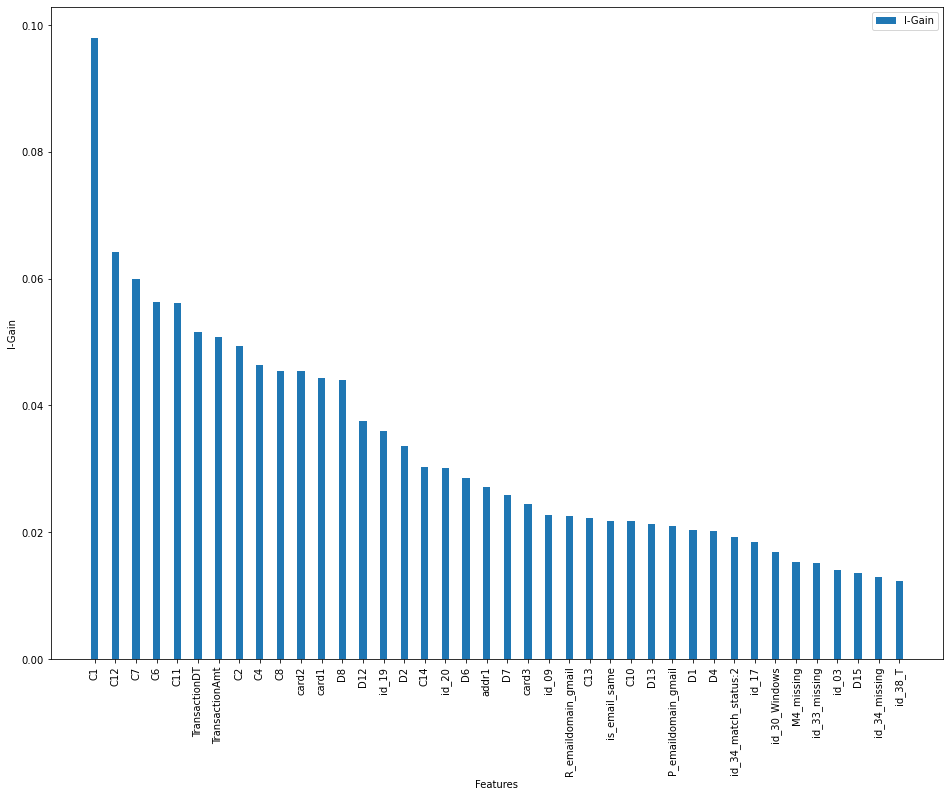

In [40]:
savedf = df
df = df[:40]

n = len(df.index)
rr = range(1,n)
fig, ax = plt.subplots()
ax.bar(df.index, df["I-Gain"], label='I-Gain',width=.35)

ax.xaxis.set_major_locator(mticker.FixedLocator(range(0,n)))
ax.set_xticklabels(list(df.index), rotation = 90)

ax.set_xlabel('Features')
ax.set_ylabel('I-Gain')
ax.legend()

df = savedf

plt.show()


In [41]:
percent_missing = X_train.isna().sum() / len(X_train)
percent_missing.sort_values(ascending=False)[:40]

TransactionDT                 0.0
id_23_IP_PROXY:TRANSPARENT    0.0
id_27_Found                   0.0
id_27_NotFound                0.0
id_27_missing                 0.0
id_28_Found                   0.0
id_28_New                     0.0
id_29_Found                   0.0
id_29_NotFound                0.0
id_30_Android                 0.0
id_30_Mac                     0.0
id_30_Windows                 0.0
id_30_iOS                     0.0
id_30_missing                 0.0
id_30_other                   0.0
id_31_android                 0.0
id_31_chrome                  0.0
id_23_missing                 0.0
id_23_IP_PROXY:HIDDEN         0.0
R_emaildomain_hotmail         0.0
id_23_IP_PROXY:ANONYMOUS      0.0
R_emaildomain_other           0.0
R_emaildomain_outlook         0.0
R_emaildomain_yahoo           0.0
M4_M0                         0.0
M4_M1                         0.0
M4_M2                         0.0
M4_missing                    0.0
id_12_Found                   0.0
id_12_NotFound

In [42]:
percent_missing = y_train.isna().sum() / len(y_train)
percent_missing

0.0

# Now fix my test to match train

In [43]:
def fix_test_set(test):
    # using the same start as train, so the days makes sense, they mightn't be the actual correct days but hey 
    test["TransactionDAYOFWEEK"] = test["TransactionDT"].apply(lambda x: start + pd.Timedelta(seconds=x)).dt.day_name()
    test.columns=test.columns.str.replace('-','_')
    print("dropping these:", columns_dropped)
    print(test.shape)
    test.drop(columns=columns_dropped, inplace=True)
    print(test.shape)
    
    imp = SimpleImputer(strategy='constant', fill_value='missing')
    imp.fit(test[test.columns[test.dtypes == object]])
    test[test.columns[test.dtypes == object]] = imp.transform(test[test.columns[test.dtypes == object]])

    
    test['is_email_same'] = test.apply(lambda x: x['P_emaildomain']== x['R_emaildomain'] and x['R_emaildomain'] != np.nan, axis=1)
    test.loc[test['P_emaildomain'].isna(), 'P_emaildomain'] = "missing"
    for i in email_repl:
        test.loc[test['P_emaildomain'].str.contains(i), 'P_emaildomain'] = i
    test.loc[~test['P_emaildomain'].isin(email_repl), 'P_emaildomain'] = "other"

    test.loc[test['R_emaildomain'].isna(), 'R_emaildomain'] = "missing"
    for i in email_repl:
        test.loc[test['R_emaildomain'].str.contains(i), 'R_emaildomain'] = i
    test.loc[~test['R_emaildomain'].isin(email_repl), 'R_emaildomain'] = "other"

    test.loc[test['id_31'].isna(), 'id_31'] = "missing"
    for i in id_31_repl:
        test.loc[test['id_31'].str.contains(i), 'id_31'] = i
    test.loc[~test['id_31'].isin(id_31_repl), 'id_31'] = "other"

    test.loc[test['id_30'].isna(), 'id_30'] = "missing"
    for i in id_30_repl:
        test.loc[test['id_30'].str.contains(i), 'id_30'] = i
    test.loc[~test['id_30'].isin(id_30_repl), 'id_30'] = "other"

    test.loc[test['id_33'].isna(), 'id_33'] = "missing"
    for i in id_33_repl:
        test.loc[test['id_33'].str.contains(i), 'id_33'] = i
    test.loc[~test['id_33'].isin(id_33_repl), 'id_33'] = "other"

    test.loc[test['DeviceInfo'].isna(), 'DeviceInfo'] = "missing"
    for i in DeviceInfo_repl:
        test.loc[test['DeviceInfo'].str.contains(i), 'DeviceInfo'] = i
    test.loc[~test['DeviceInfo'].isin(DeviceInfo_repl), 'DeviceInfo'] = "other"
    test['DeviceInfo'].value_counts().head(15)
#     test[["id_35","id_36","id_37","id_38"]] = test[["id_35","id_36","id_37","id_38"]].apply(convert_binary)
    
    imp = SimpleImputer(strategy='constant', fill_value='missing')
    imp.fit(test[not_num_cols])
    test[not_num_cols] = imp.transform(test[not_num_cols])
    
    test.reset_index(inplace=True)
    for col in not_num_cols:
        test = onehot(df=test, col=str(col), categories=train_hot_categories[col])
    
    scaler = StandardScaler()
#     scaler = RobustScaler(quantile_range=(25, 75))
    test[num_cols] = scaler.fit_transform(test[num_cols])
    

    nan_cols = test.columns[(test.isna().any())  & (test.nunique() != 2) & ((test.isna().sum() / len(test)) < 0.40)]
    print("missing:", dict(test[nan_cols].isna().mean()))
    print("KNNImputer cols:", nan_cols)
#     # done in chunks cause or else be here all day
#     for i in range(0, len(nan_cols), 2):
#         chunk = nan_cols[i:i+2]
#         print(chunk)
#         imp_kNN = KNNImputer(missing_values = np.nan, n_neighbors=5)
#         imp_kNN.fit(test[chunk])
#         test[chunk] = imp_kNN.transform(test[chunk])
#         print(test.shape)
        
    imp_kNN = KNNImputer(missing_values = np.nan, n_neighbors=3)
    imp_kNN.fit(test[nan_cols])
    test[nan_cols] = imp_kNN.transform(test[nan_cols])
    print(test.shape)
        
    nan_cols = test.columns[(test.isna().any())  & (test.nunique() == 2) | ((test.isna().sum() / len(test)) > 0.40) ]
    print("SimpleImputer cols:", nan_cols)
    imp = SimpleImputer(missing_values=np.nan, strategy='median')
    imp.fit(test[nan_cols])
    test[nan_cols] = imp.transform(test[nan_cols])

    test.set_index("TransactionID", inplace=True)
    test.drop(columns="index", inplace=True)
    
    return test


In [44]:
test = fix_test_set(test)
y_test = test['isFraud']
X_test = test.drop('isFraud', axis=1)

dropping these: ['dist1', 'D11', 'id_24', 'id_08', 'id_07', 'id_25', 'id_26', 'id_21', 'id_22', 'C5', 'C9', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9']
(33334, 96)
(33334, 77)
using ProductCD ['C', 'H', 'R', 'S']
unique values: ['W', 'R', 'H', 'C', 'S']
get_feature_names: ['ProductCD_C' 'ProductCD_H' 'ProductCD_R' 'ProductCD_S']
categories_: [array(['C', 'H', 'R', 'S'], dtype=object)]
hot_array.columns Index(['ProductCD_C', 'ProductCD_H', 'ProductCD_R', 'ProductCD_S'], dtype='object')
using card4 ['american express', 'discover', 'mastercard', 'missing', 'visa']
unique values: ['visa', 'mastercard', 'american express', 'discover', 'missing']
get_feature_names: ['card4_american express' 'card4_discover' 'card4_mastercard'
 'card4_missing' 'card4_visa']
categories_: [array(['american express', 'discover', 'mastercard', 'missing', 'visa'],
      dtype=object)]
hot_array.columns Index(['card4_american express', 'card4_discover', 'card4_mastercard',
       'card4_missing', 'card4_visa'],

using id_38 ['F', 'T']
unique values: ['missing', 'T', 'F']
get_feature_names: ['id_38_F' 'id_38_T']
categories_: [array(['F', 'T'], dtype=object)]
hot_array.columns Index(['id_38_F', 'id_38_T'], dtype='object')
using DeviceType ['desktop', 'mobile']
unique values: ['missing', 'desktop', 'mobile']
get_feature_names: ['DeviceType_desktop' 'DeviceType_mobile']
categories_: [array(['desktop', 'mobile'], dtype=object)]
hot_array.columns Index(['DeviceType_desktop', 'DeviceType_mobile'], dtype='object')
using DeviceInfo ['missing', 'moto', 'other', 'rv']
unique values: ['missing', 'rv', 'other', 'moto']
get_feature_names: ['DeviceInfo_missing' 'DeviceInfo_moto' 'DeviceInfo_other' 'DeviceInfo_rv']
categories_: [array(['missing', 'moto', 'other', 'rv'], dtype=object)]
hot_array.columns Index(['DeviceInfo_missing', 'DeviceInfo_moto', 'DeviceInfo_other',
       'DeviceInfo_rv'],
      dtype='object')
using TransactionDAYOFWEEK ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'W

In [45]:
print("X_train shape: ",X_train.shape)
print("X_test shape: ",X_test.shape)
print("y_train.value_counts: ",y_train.value_counts())
print("y_test.value_counts: ",y_test.value_counts())

X_train shape:  (5218, 149)
X_test shape:  (33334, 149)
y_train.value_counts:  0    4528
1     690
Name: isFraud, dtype: int64
y_test.value_counts:  0    32209
1     1125
Name: isFraud, dtype: int64


In [ ]:
c = GaussianNB()
# c = MLPClassifier(max_iter=2000, random_state=2,
#                     hidden_layer_sizes=[20])
# c = SVC(kernel = 'linear',C=1, probability=True) 

acc_scores = []
roc_scores = []
amount_features = 50
print("shape:", train.shape[1], "using", amount_features)
for kk in range(1, amount_features):
    print(kk)
    FS_trans = SelectKBest(mutual_info_classif, 
                           k=kk).fit(X_train, y_train)
    X_tR_new = FS_trans.transform(X_train)
    X_tS_new = FS_trans.transform(X_test)
    Fraud_NB = c.fit(X_tR_new, y_train)
    y_dash = Fraud_NB.predict(X_tS_new)
    acc = accuracy_score(y_test, y_dash)
    roc = roc_auc_score(y_test, y_dash)
    print(kk,acc, roc)
    acc_scores.append(acc)
    roc_scores.append(roc)


shape: 150 using 50
1
1 0.9662506749865003 0.5
2
2 0.9662506749865003 0.5
3
3 0.9662506749865003 0.5
4
4 0.9662506749865003 0.5
5
5 0.9662506749865003 0.5
6
6 0.9662506749865003 0.5
7
7 0.9662506749865003 0.5
8
8 0.9662506749865003 0.5
9
9 0.9662506749865003 0.5
10
10 0.9662506749865003 0.5
11
11 0.9662506749865003 0.5
12
12 0.3877722445551089 0.5197753008993345
13
13 0.3642527149457011 0.5333400395334638
14
14 0.3469430611387772 0.5355348574070049
15
15 0.30266394672106556 0.4937494903080919
16
16 0.32135357292854144 0.5394500501930102
17
17 0.2650746985060299 0.5609404134800142
18
18 0.2795344093118138 0.5512659608598011
19
19 0.125517489650207 0.4943005440163377
20
20 0.26183476330473393 0.563124150944698
21


In [ ]:
df = df.iloc[:amount_features-1]
df['Accuracy'] = acc_scores
df['ROC AUC Score'] = roc_scores
df.head(20)

In [ ]:
n = len(df.index)
rr = range(1,n)
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.bar(df.index, df["I-Gain"], label='I-Gain',width=.35)
ax2.plot(df.index, df["Accuracy"], color='red', label='Accuracy')
ax2.plot(df.index, df["ROC AUC Score"], color='green', label='ROC AUC Score')

ax.xaxis.set_major_locator(mticker.FixedLocator(range(0,n)))

ax.set_xticklabels(list(df.index), rotation = 90)

ax.set_xlabel('Features')
# ax.set_ylabel('I-Gain')
ax2.set_ylabel('Accuracy/ ROC')
ax.legend()
ax2.legend()
plt.show()

# trying feature selction with SequentialFeatureSelector

In [ ]:
feature_names = X_train.columns
print(list(feature_names))

In [ ]:
sfs_forward = SequentialFeatureSelector(
                KNeighborsClassifier(n_neighbors=3),
                k_features=15,
                forward=True,
                floating=False,
                verbose=1,
                scoring='roc_auc',
                cv=5,
                n_jobs=-1,
                pre_dispatch='2*n_jobs',
                clone_estimator=True,
                fixed_features=None,
            )

sfs_forward = sfs_forward.fit(X_train, y_train, 
                              custom_feature_names=feature_names)
from mlxtend.plotting import plot_sequential_feature_selection

fig1 = plot_sequential_feature_selection(sfs_forward.get_metric_dict(), 
                ylabel='roc_auc',
                kind='std_dev')

plt.ylim([0.6, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()
print(sfs_forward.k_feature_names_)

# Trying Lasso feature selection

In [ ]:
lr_selector = SelectFromModel(LogisticRegression(penalty="l1", 
                     C=.01, solver="liblinear"), max_features=X_train.shape[1])
lr_selector.fit(X_train, y_train)

X = pd.DataFrame(X_train)
lr_support = lr_selector.get_support()
lr_feature = X.loc[:,lr_support].columns.tolist()
print(str(len(lr_feature)), 'selected features')  
print('Selected features:')
lr_feature

# Compare models and evaluate

In [ ]:
feature_names_dict = {"ALL": X_train.columns, 
                      "SEL1":list(sfs_forward.k_feature_names_)}


In [ ]:
lreg = LogisticRegression(solver='liblinear')
kNN = KNeighborsClassifier(n_neighbors=3)  
gnb = GaussianNB()
bnb = BernoulliNB()
dtree = DecisionTreeClassifier(criterion='entropy')
svm = SVC(kernel = 'linear',C=1, probability=True)  
mlp1 = MLPClassifier(max_iter=2000, random_state=2,
                    hidden_layer_sizes=[20])
mlp2 = MLPClassifier(solver='lbfgs',random_state=0, max_iter=100)
models = [lreg,kNN,gnb,bnb,dtree,svm,mlp1,mlp2]  

In [ ]:
print('ROC Analysis')
plt.figure()
lw = 2
roc_results = []
clist = list(mcolors.TABLEAU_COLORS) + list(mcolors.TABLEAU_COLORS)
for k, v in feature_names_dict.items():
    for m in models:
        m.fit(X_train[v], y_train)
        y_dash = m.predict(X_test[v])
        y_score = m.predict_proba(X_test[v])
        acc = accuracy_score(y_test, y_dash)
        roc = roc_auc_score(y_test, y_dash)
        details = str(m.get_params).replace("bound method BaseEstimator.get_params of ","")
        
        fprG, tprG, t = roc_curve(y_test, y_score[:,1])
        roc_aucG = auc(fprG, tprG)
        if k = "ALL":
            plt.plot(fprG, tprG, color=clist.pop(),
             lw=lw, label='{} ROC {} (area = {})'.format(k, type(m).__name__, roc_aucG))

        print("{:5.5}   {:22.22} Accuracy:{:4.4}\t\tROC:{:4.4}\t\tROC_AUC PROB:{:4.4}\t{}".format(k, type(m).__name__, acc, roc, roc_aucG, details))
        roc_results.append([k, type(m).__name__, acc, roc, details])
        


        
roc_results_df = pd.DataFrame(roc_results, columns = ['features','name','acc',"roc", "get_params"])

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Analysis for isFraud data')
plt.legend(loc="lower right")
plt.show()

In [ ]:
roc_results_df.sort_values(["roc","acc"], ascending=False).reset_index(drop=True)

In [ ]:
mlp1 = MLPClassifier(max_iter=2000, random_state=2,
                    hidden_layer_sizes=[20])
# train = pd.read_pickle("train_FULL.pkl")
y_train = train['isFraud']
X_train = train.drop('isFraud', axis=1)
mlp1.fit(X_train[sfs_forward.k_feature_names_], y_train)

In [ ]:
# kNN.fit(X,y)

# Now for the Kaggle Test dataset

In [ ]:
if not skip_start:
    test_identity = pd.read_csv('data/ieee-fraud-detection/test_identity.csv')
    test_transaction = pd.read_csv('data/ieee-fraud-detection/test_transaction.csv')

In [ ]:
if not skip_start:
    test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')
    test = test.drop(columns=[x for x in test.columns if x.startswith("V")])
    test.shape

In [ ]:
if not skip_start:
    del test_identity, test_transaction
    gc.collect()
    test.to_pickle("test.pkl")

In [ ]:
if skip_start:
    test = pd.read_pickle("test.pkl")
if speed:
    test = test.sample(n=10000)

### need to set value for the test set

In [ ]:
test["isFraud"] = "test"

In [ ]:
test.columns=test.columns.str.replace('-','_')

In [ ]:
test = fix_test_set(test)
y_test = test['isFraud']
X_test = test.drop('isFraud', axis=1)

In [ ]:
X_test.shape, y_test.shape

In [ ]:
# y_test.to_pickle("y_test.pkl")
# X_test.to_pickle("X_test.pkl")

In [ ]:
test_isFraud_prob = mlp1.predict_proba(test.drop('isFraud', axis=1))
test_isFraud_prob[:,1][:10]

In [ ]:
def package_for_kaggle(test_isFraud_prob):
    submission = pd.DataFrame({"TransactionID": test.index, "isFraud": test_isFraud_prob[:,1]}) 
    submission.to_csv("data/submission.csv", index=False)
    
package_for_kaggle(test_isFraud_prob)

In [ ]:
print(test.shape)